In [1]:
from plantcv import plantcv as pcv
import numpy as np
import os 
import matplotlib 


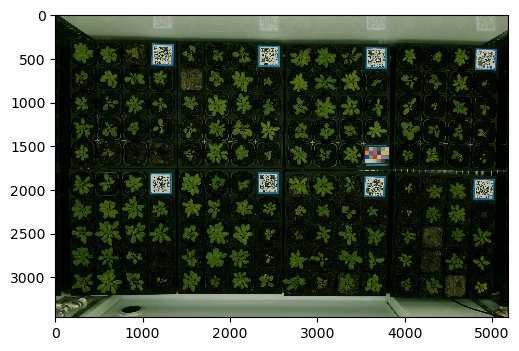

In [2]:
class options:
    def __init__(self):        
        self.image = "BVZ0072-GC35L-RGB01_fullres-cor_2016_10_12_16_45_00_00.jpg"
        self.debug = "plot"
        self.writeimg = False
        self.result = "results.txt"
        self.outdir = "."

args = options()
pcv.params.outdir = args.outdir
pcv.params.debug = args.debug

# Read the image 
img, path, filename = pcv.readimage(filename=args.image)


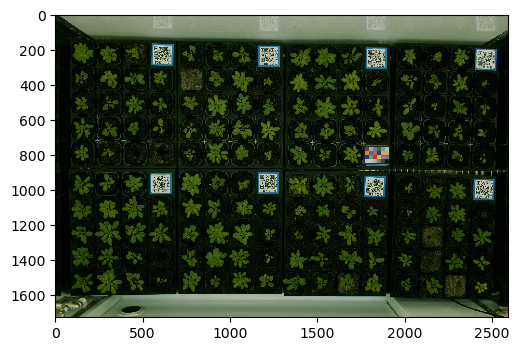

In [3]:
# Resize since the for loop at the end was crashing jupyter

img = pcv.resize(img, 0.5, 0.5)


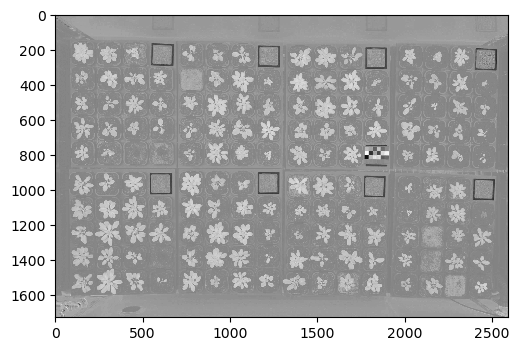

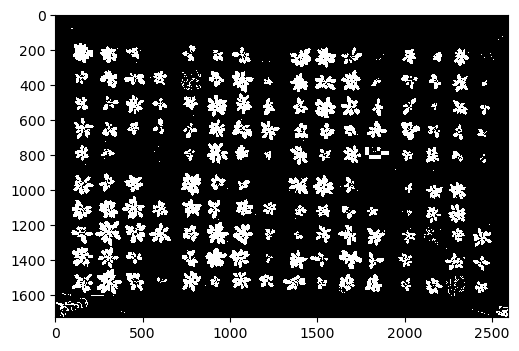

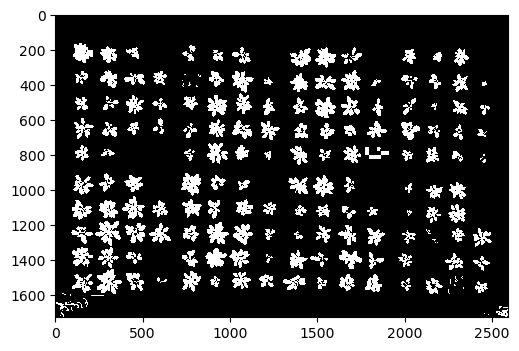

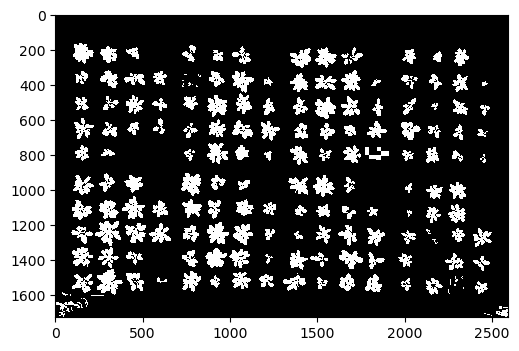

In [4]:
#### Create a mask and begin to clean it ####

# Change color space for plant extraction
b = pcv.rgb2gray_lab(rgb_img=img, channel="b")
# Threshold
b_thresh = pcv.threshold.binary(gray_img=b, threshold=150, max_value=255, object_type='light')
# Fill in small objects 
b_fill_image = pcv.fill(bin_img=b_thresh, size=50)
# Dilate 
b_dilated = pcv.dilate(gray_img=b_fill_image, ksize=2, i=1)


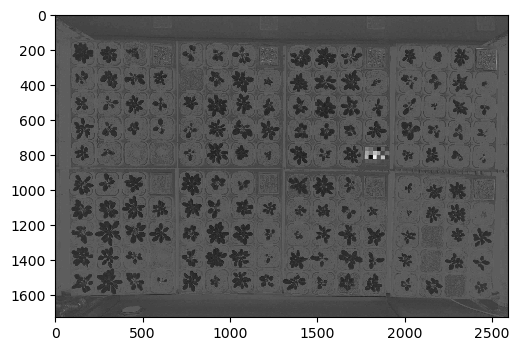

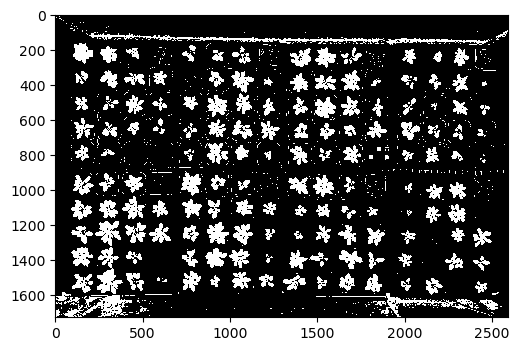

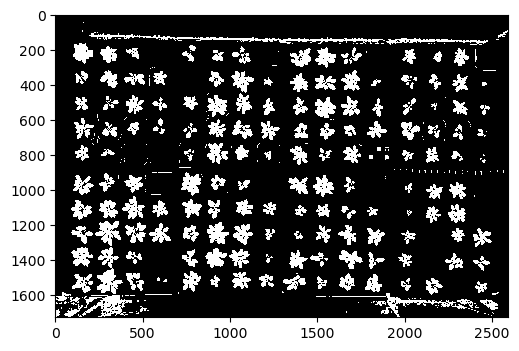

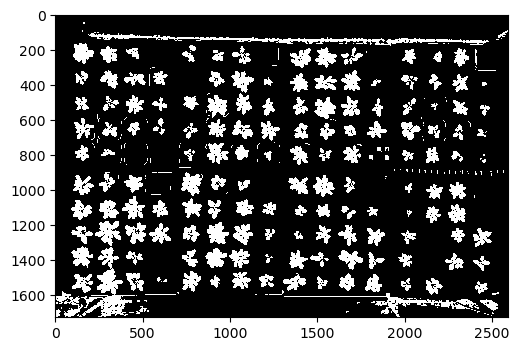

In [5]:
# Change color space for plant extraction, using two channels is often better than using just one. 
a = pcv.rgb2gray_lab(rgb_img=img, channel="a")
# Threshold
a_thresh = pcv.threshold.binary(gray_img=a, threshold=114, max_value=255, object_type='dark')
# Fill in small objects 
a_fill_image = pcv.fill(bin_img=a_thresh, size=50)
# Dilate 
a_dilated = pcv.dilate(gray_img=a_fill_image, ksize=2, i=1)


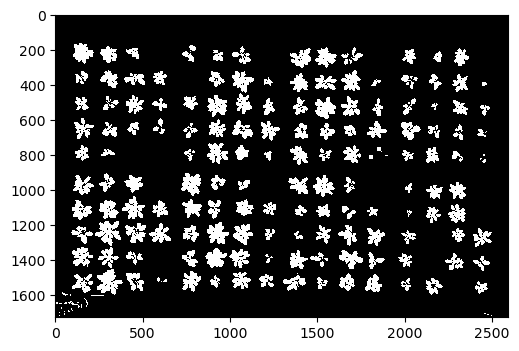

In [6]:
# Use logical and on the masks greated 
combined_mask = pcv.logical_and(bin_img1=b_dilated, bin_img2=a_dilated)

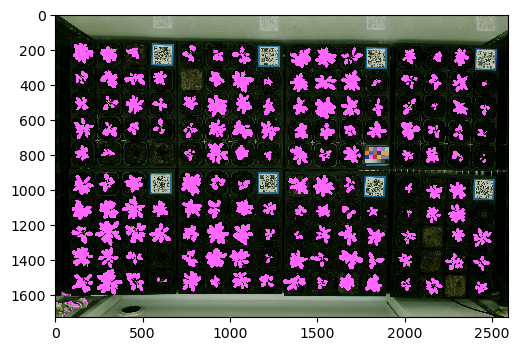

In [7]:
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=combined_mask)


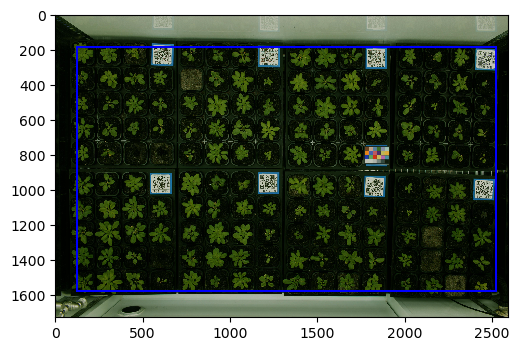

In [8]:
# Increase line thickness since images are very large
pcv.params.line_thickness=10

# Define region of interest 
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img, x=125, y=180, h=1400, w=2400)


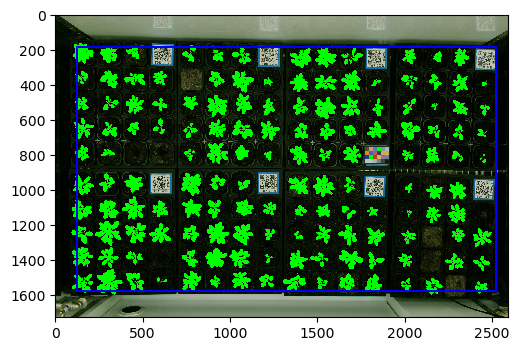

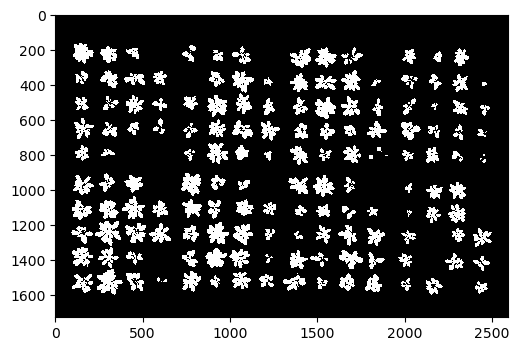

In [9]:
# Keep objects that overlap with the ROI 
roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi_contour, 
                                                                      roi_hierarchy=roi_hierarchy,
                                                                      object_contour=id_objects,
                                                                      obj_hierarchy=obj_hierarchy, 
                                                                      roi_type='partial')

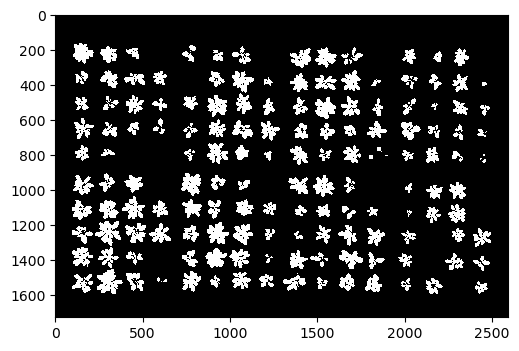

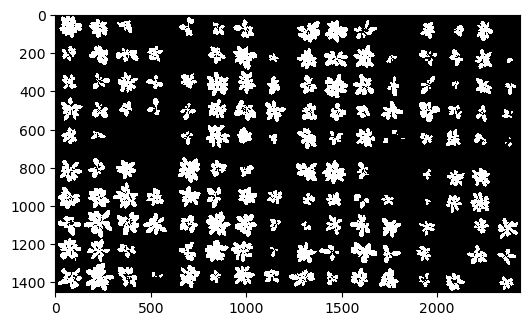

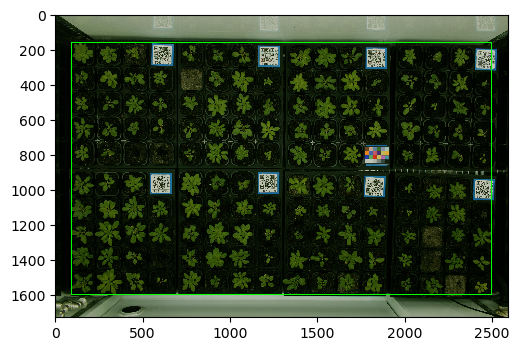

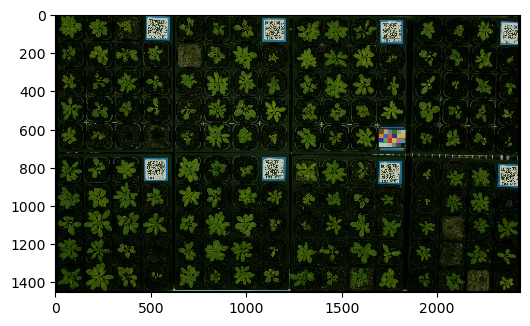

In [10]:
# Crop the image and the mask so that a grid can be fit to just the plants 

cropped_mask = pcv.auto_crop(img=kept_mask, obj=np.vstack(roi_objects), padding_x=15, padding_y=5, color='black')
cropped_img = pcv.auto_crop(img=img, obj=np.vstack(roi_objects), padding_x=15, padding_y=5, color='black')

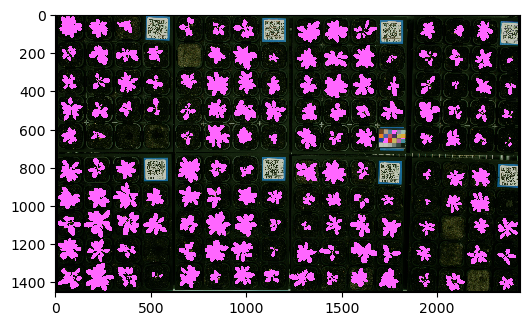

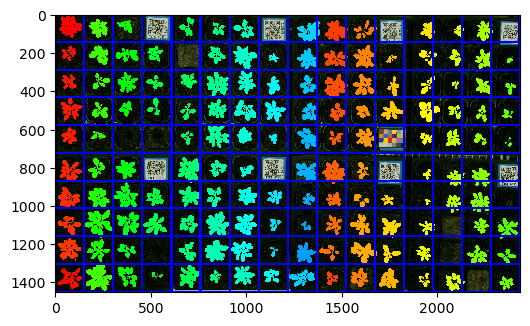

In [11]:
id_objects, obj_hierarchy = pcv.find_objects(img=cropped_img, mask=cropped_mask)


# Split images into individual plants
clusters_i, contours, hierarchies = pcv.cluster_contours(img=cropped_img, roi_objects=id_objects, 
                                                             roi_obj_hierarchy=obj_hierarchy, 
                                                             nrow=10, ncol=16, show_grid=True)

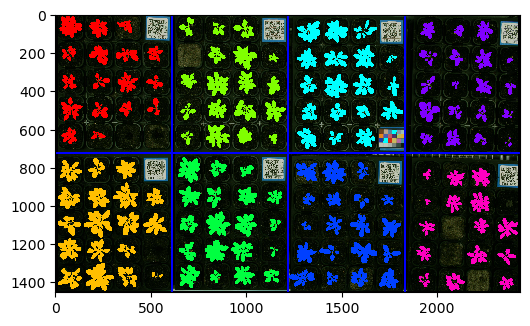

In [12]:
# Split images by flats
clusters_i, contours, hierarchies = pcv.cluster_contours(img=cropped_img, roi_objects=id_objects, 
                                                             roi_obj_hierarchy=obj_hierarchy, 
                                                             nrow=2, ncol=4, show_grid=True)

# Color Analysis 

/home/hschuhl/miniconda3/envs/plantcv/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hschuhl/miniconda3/envs/plantcv/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hschuhl/miniconda3/envs/plantcv/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hschuhl/miniconda3/envs/plantcv/lib/python3.7/site-packages/plotnine/scales/scale.py:93: Matpl

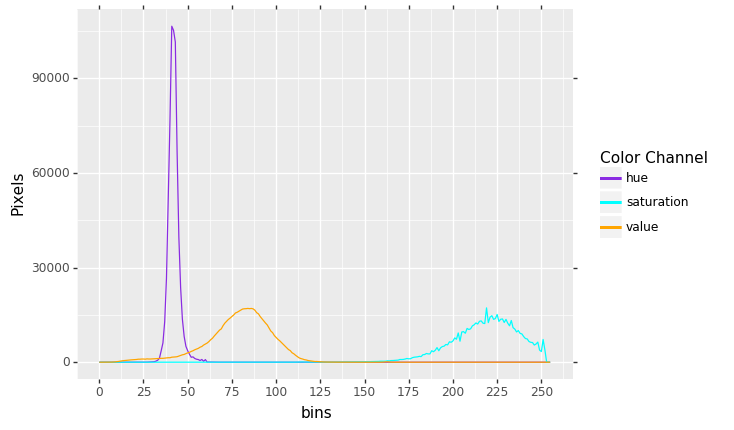

<ggplot: (2942036140885)>


In [13]:
# Analyze color 
hist_img = pcv.analyze_color(rgb_img=cropped_img, mask=cropped_mask, hist_plot_type="hsv")

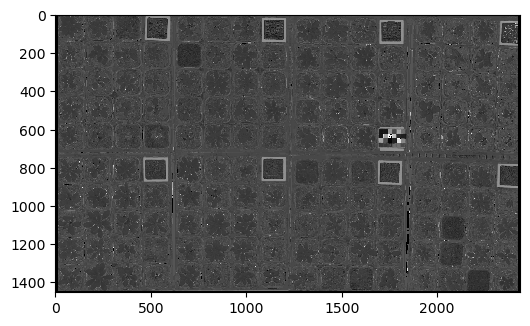

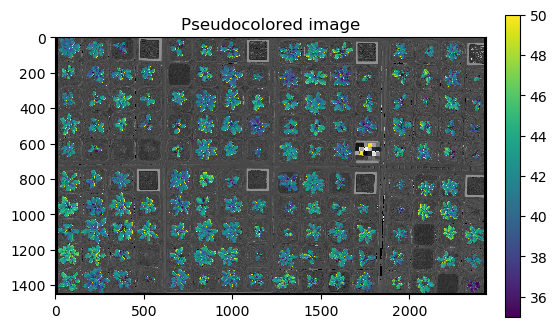

In [14]:
# Pseudocolor the image 
gray_img = pcv.rgb2gray_hsv(rgb_img=cropped_img, channel="h")
pseudo_img = pcv.visualize.pseudocolor(gray_img, obj=None, mask=cropped_mask,
                                        background="image", cmap=None, 
                                        min_value=35, max_value=50, 
                                        axes=True, colorbar=True, obj_padding='auto')

# Analyze shape

Alternative to `pcv.cluster_contours` you can also analyze individual plants (or groups of plants) using the `pcv.roi.multi` function.

<IPython.core.display.Javascript object>


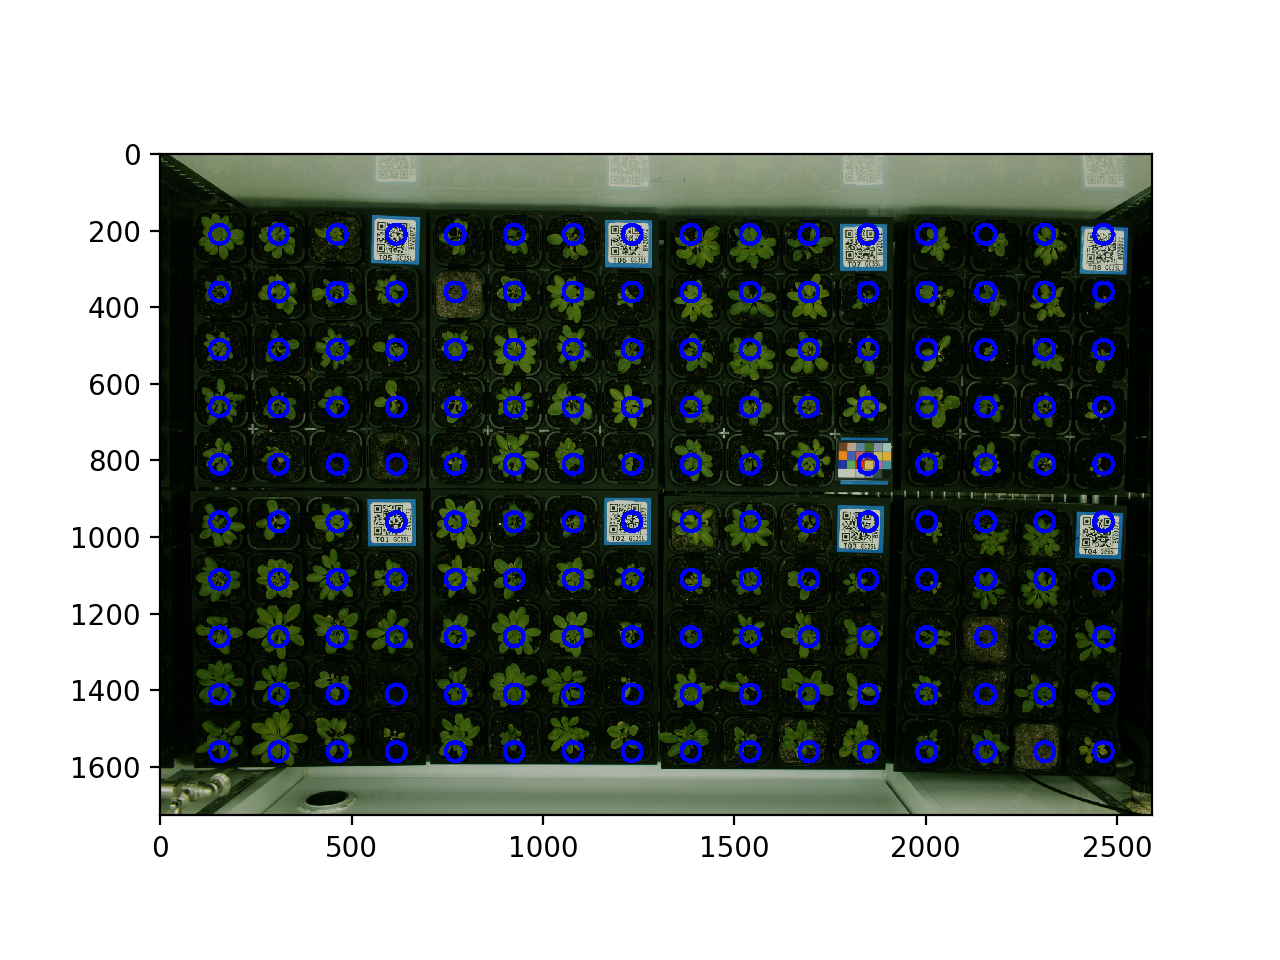

In [17]:
%matplotlib notebook
pcv.params.debug='plot'
roi_contours, roi_hierarchies = pcv.roi.multi(img=img, coord=(155, 212), radius=25, spacing=(154, 150), 
                                              nrows=10, ncols=16)

<IPython.core.display.Javascript object>


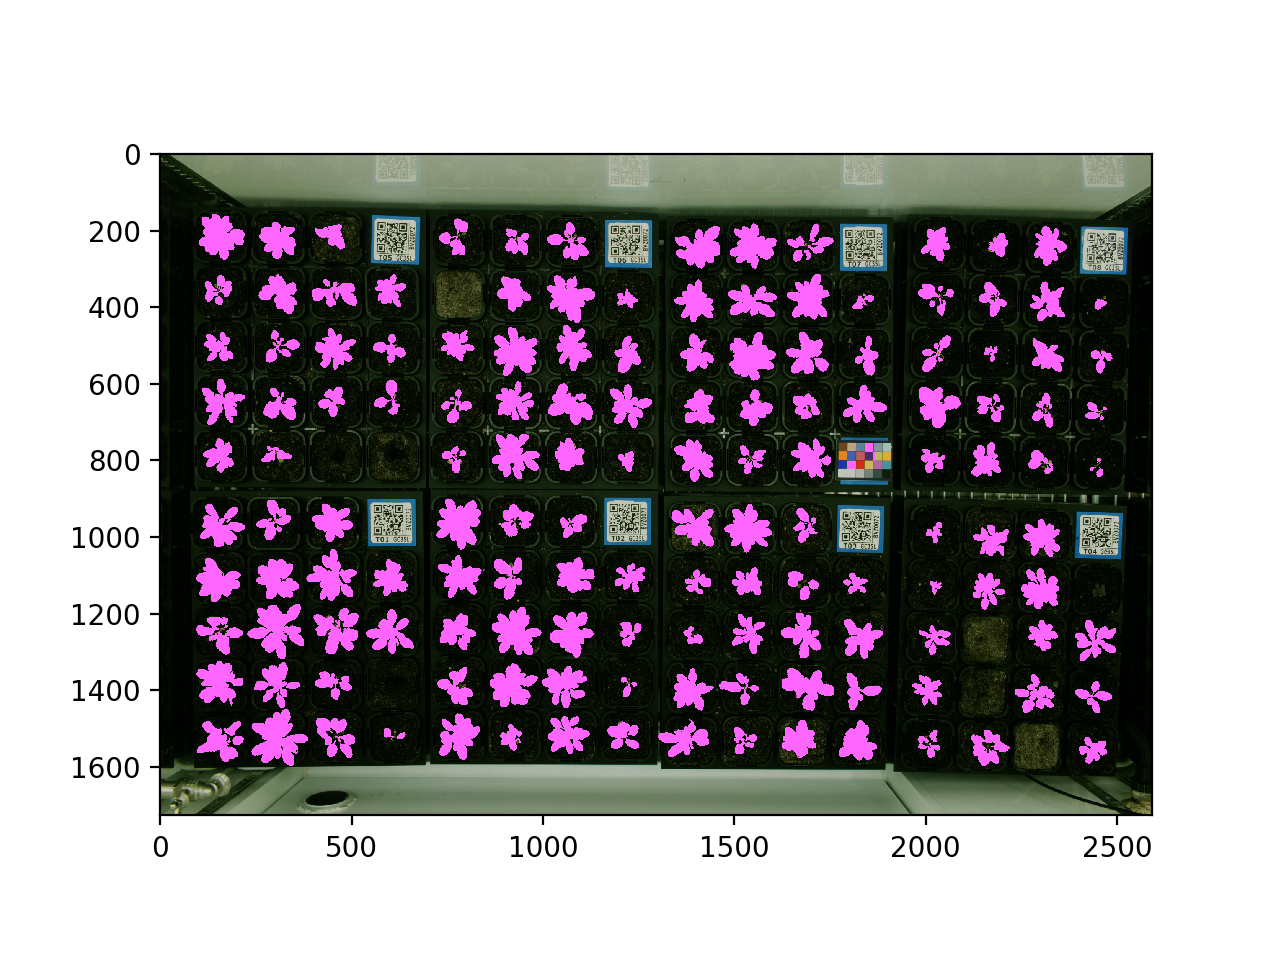

In [18]:
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=kept_mask)


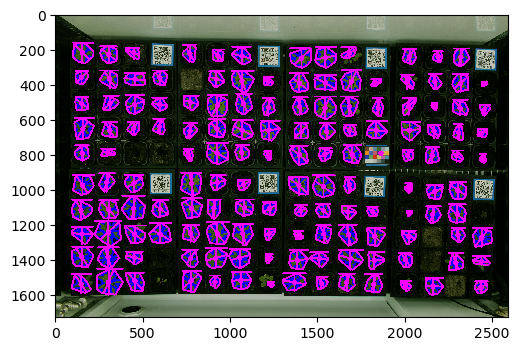

In [19]:
%matplotlib inline
import numpy as np
pcv.params.debug = None
img_copy = np.copy(img)


plant_found = []
# Loop through each region of interest defined
for i in range(0, len(roi_contours)):
    # Initialize the ROI of interest 
    roi = roi_contours[i]
    hierarchy = roi_hierarchies[i]
    plant_obj, plant_hierarchy, plant_mask, plant_area = pcv.roi_objects(
        img=img, roi_type="partial", roi_contour=roi, roi_hierarchy=hierarchy, 
        object_contour=id_objects, 
        obj_hierarchy=obj_hierarchy)
    if plant_area > 0:
        plant_found.append(True)
        # Combine objects together in each plant     
        plant_contour, plant_mask = pcv.object_composition(img=img, contours=plant_obj, 
                                                           hierarchy=plant_hierarchy)        
        # Analyze the shape of each plant 
        img_copy = pcv.analyze_object(img=img_copy, obj=plant_contour, mask=plant_mask)
            
    else: 
        plant_found.append(False)
pcv.outputs.add_observation(variable='plant_found', trait='whether or not a plant was found ',
                            method='plantcv.roi_objects, top-left is first observation', scale='None', 
                            datatype=list, value=plant_found, label=list(range(0, len(plant_found))))
pcv.plot_image(img=img_copy)
